In [ ]:
# 1.	Gerekli Kütüphanelerin Yüklenmesi
# Yüklediğim kütüphaneler veri analizleri ve manipülasyonu ( pandas) ,
# sayısal hesaplamalar, görüntü işlemeler için kullanılan yaygın kütüphanelerdir.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from tensorflow import keras
import kagglehub
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image


!pip install pandas numpy scikit-learn tensorflow


Path to dataset files: /content/drive/MyDrive/mask
with_mask sınıfı image sayısı: 1532
with_mask sınıfı örnek image


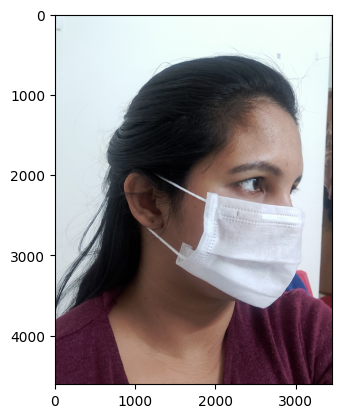

without_mask sınıfı image sayısı: 3828
without_mask sınıfı örnek image


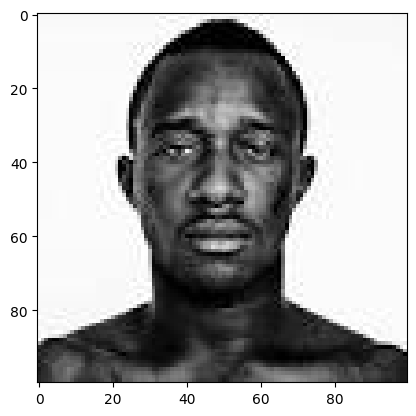

Toplam Image Sayısı: 5360
Toplam Etiket Sayısı_1: 5360
Toplam Etiket Sayısı_2: 5360


In [ ]:
#2.	Veri Seti Yükleme
# İlgili veri setini önce kaggle dan api ile getirmeye çalıştım ama düzgün çalışmadığı için drive da mask klasörü içinde tutmaya karar verdim.
# Dataset path
data_path = '/content/drive/MyDrive/mask'
data_image = []

print("Path to dataset files:", data_path)

# İki sınıfla (with_mask, without_mask) klasörler üzerinden döngü
for class_path in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_path)

    print(f"{class_path} sınıfı image sayısı: {len(os.listdir(class_folder_path))}")
    print(f"{class_path} sınıfı örnek image")

# Rastgele seçtiğim 2 adet resmi ekrana getirdim.

    if class_path == 'with_mask':
        with_mask_label_2 = [[1, 0]] * len(os.listdir(class_folder_path))
        with_mask_label_1 = [1] * len(os.listdir(class_folder_path))
        img = mimg.imread(os.path.join(class_folder_path, 'with_mask_3127.jpg'))
        imgplot = plt.imshow(img)
        plt.show()
    else:
        without_mask_label_2 = [[0, 1]] * len(os.listdir(class_folder_path))
        without_mask_label_1 = [0] * len(os.listdir(class_folder_path))
        img = mimg.imread(os.path.join(class_folder_path, 'without_mask_1.jpg'))
        imgplot = plt.imshow(img)
        plt.show()

    # Görselleri 128x128 boyutuna yeniden boyutlandır ve RGB'ye çevir
    for img_file in os.listdir(class_folder_path):
        image = Image.open(os.path.join(class_folder_path, img_file))
        image = image.resize((128, 128))
        image = image.convert('RGB')
        image = np.array(image)
        data_image.append(image)

# Etiketler
data_label_1 = with_mask_label_1 + without_mask_label_1
data_label_2 = with_mask_label_2 + without_mask_label_2

print(f"Toplam Image Sayısı: {len(data_image)}")
print(f"Toplam Etiket Sayısı_1: {len(data_label_1)}")
print(f"Toplam Etiket Sayısı_2: {len(data_label_2)}")

In [ ]:
#3.	Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması
# Özellikle mobil cihazlarda ve gömülü sistemlerde kullanılmak üzere tasarlanmış verimli bir derin öğrenme modelidir.
# Google tarafından geliştirilen bu model, görüntü sınıflandırma gibi görevler için optimize edilmiştir.
# Amaç, yüksek doğrulukla birlikte daha düşük hesaplama gücü ve bellek gereksinimlerine sahip bir model sunmaktır.

base_modelMNet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_modelMNet.layers:
    layer.trainable = False

x = base_modelMNet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictionsMNet = Dense(2, activation='softmax')(x)

modelMNet = Model(inputs=base_modelMNet.input, outputs=predictionsMNet)

modelMNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelMNet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,532,546 (13.48 MB)

 Trainable params: 303,682 (1.16 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
#4.Veri Setinin Eğitim/Validasyon ve Test Olarak ayrıldı.

# Veri setini eğitim/validasyon ve test olarak ayırma
X_train_val, X_test, y_train_val, y_test = train_test_split(
    np.array(data_image), np.array(data_label_2), test_size=0.2, random_state=42
)

# Eğitim ve validasyon setlerini ayırma (örneğin %80 eğitim, %20 validasyon)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

print("Eğitim seti boyutu:", X_train.shape)
print("Validasyon seti boyutu:", X_val.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (3430, 128, 128, 3)
Validasyon seti boyutu: (858, 128, 128, 3)
Test seti boyutu: (1072, 128, 128, 3)


In [ ]:
# 5. Daha önce ayırdığınız eğitim+validasyon verisini %80’i eğitim %20’si validasyon olarak rastgele böldük ve  Eğitim verisine  veri arttırımı uyguladık.

# Veri arttırma için ImageDataGenerator oluşturma
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Veri arttırma işlemini sadece eğitim verisine uygula
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=32  # batch_size'ı ihtiyaca göre ayarlayın
)

# Model eğitimi (veri arttırma ile)
history = modelMNet.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # batch_size'a göre ayarlayın
    epochs=10,  # epoch sayısını ihtiyaca göre ayarlayın
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    ]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 92s 761ms/step - accuracy: 0.7728 - loss: 0.4726 - val_accuracy: 0.9149 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 2/10
  1/107 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - accuracy: 0.8750 - loss: 0.3672

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.8750 - loss: 0.3672 - val_accuracy: 0.9138 - val_loss: 0.2200 - learning_rate: 0.0010
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 123s 771ms/step - accuracy: 0.8796 - loss: 0.3125 - val_accuracy: 0.9184 - val_loss: 0.2051 - learning_rate: 0.0010
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.8750 - loss: 0.2616 - val_accuracy: 0.9184 - val_loss: 0.2026 - learning_rate: 0.0010
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 125s 728ms/step - accuracy: 0.8742 - loss: 0.3035 - val_accuracy: 0.9254 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.8438 - loss: 0.3078 - val_accuracy: 0.9289 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 721ms/step - accuracy: 0.8892 - loss: 0.2705 - val_accuracy: 0.9254 - val_loss: 0.1964 - learning_rate: 1.0000e-04
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 1.0000 -

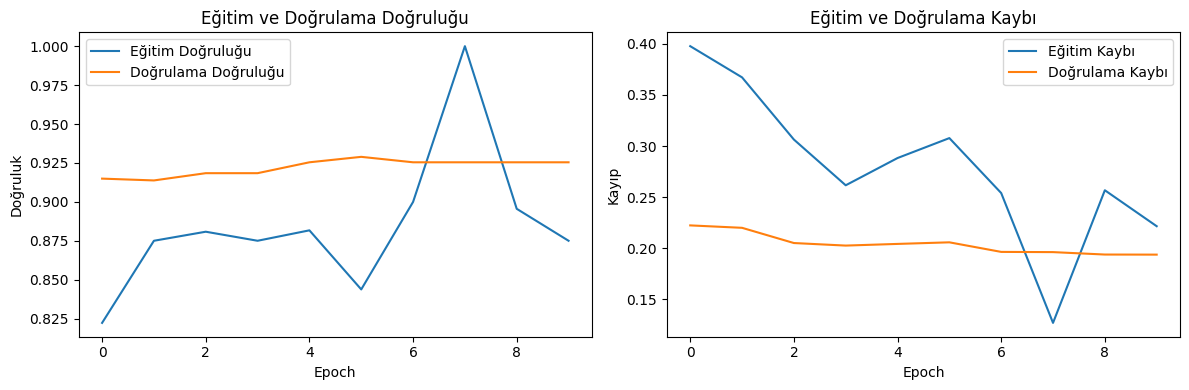

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu') # Changed historyDense to history
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu') # Changed historyDense to history
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı') # Changed historyDense to history
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı') # Changed historyDense to history
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [ ]:
x = base_modelDense.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # <-- Dropout Eklendi
x = Dense(64, activation='relu')(x)
predictionsDense = Dense(2, activation='softmax')(x)

modelDense = Model(inputs=base_modelDense.input, outputs=predictionsDense)

model_optimizerDense = SGD(learning_rate=0.0001, momentum=0.9)

modelDense.compile(optimizer=model_optimizerDense, loss='categorical_crossentropy', metrics=['accuracy'])

modelDense.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_14         │ (None, 134, 134, 3)    │              0 │ input_layer_12[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d_14[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_15         │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_15[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,177,090 (27.38 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Modellerimizi 100 epoch boyunca eğittik.

# "Epoch 100" ifadesi, modelin eğitim sürecinin 100. defasında olduğunu gösterir. Başka bir deyişle, eğitim verisinin 100 kez tümüyle modellenmiş ve bu süre zarfında modelin parametreleri güncellenmiştir.

# Model eğitimi (veri arttırma ile)
history = modelMNet.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # batch_size'a göre ayarlayın
    epochs=100,  # epoch sayısını 100 olarak ayarlayın
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    ]
)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 86s 774ms/step - accuracy: 0.9086 - loss: 0.2448 - val_accuracy: 0.9266 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 2/100
  1/107 ━━━━━━━━━━━━━━━━━━━━ 40s 378ms/step - accuracy: 0.9062 - loss: 0.2928

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9062 - loss: 0.2928 - val_accuracy: 0.9266 - val_loss: 0.1921 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 113s 726ms/step - accuracy: 0.9006 - loss: 0.2485 - val_accuracy: 0.9312 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.8750 - loss: 0.2853 - val_accuracy: 0.9312 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 119s 698ms/step - accuracy: 0.8937 - loss: 0.2379 - val_accuracy: 0.9277 - val_loss: 0.1876 - learning_rate: 1.0000e-04
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9062 - loss: 0.2036 - val_accuracy: 0.9277 - val_loss: 0.1876 - learning_rate: 1.0000e-05


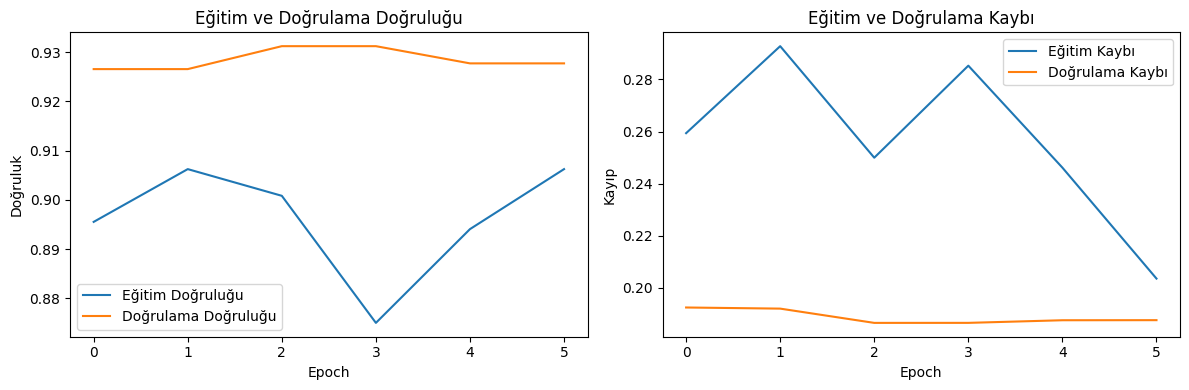

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [ ]:
# Özellikle mobil cihazlarda ve gömülü sistemlerde kullanılmak üzere tasarlanmış verimli bir derin öğrenme modelidir.
# Google tarafından geliştirilen bu model, görüntü sınıflandırma gibi görevler için optimize edilmiştir.
# Amaç, yüksek doğrulukla birlikte daha düşük hesaplama gücü ve bellek gereksinimlerine sahip bir model sunmaktır.
base_modelMNet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_modelMNet.layers:
    layer.trainable = False

x = base_modelMNet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictionsMNet = Dense(2, activation='softmax')(x)

modelMNet = Model(inputs=base_modelMNet.input, outputs=predictionsMNet)

modelMNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelMNet.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,368,450 (12.85 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# ImageDataGenerator, Keras ve TensorFlow gibi derin öğrenme kütüphanelerinde kullanılan bir sınıftır ve özellikle görüntü verisiyle
# çalışırken eğitim verisini artırmak (data augmentation) ve ön işleme yapmak için kullanılır.

X2_train = X_train
Y2_train = y_train
X2_val = X_val
Y2_val = y_val

# Continue with your code
datagenMNet = ImageDataGenerator(
    rescale=1./255,  # Pikcel değerlerini 0 ile 1 arasında normalize ediyoruz.
    rotation_range=10,  # Resimleri 10 derece döndürdük
    width_shift_range=0.1,  # Resimleri yatay eksende %10 kadar kaydırdık.
    height_shift_range=0.1,  # Resimleri dikey eksende %10 kadar kaydırdık.
    shear_range=0.1,  # Resimlerin üzerinde kesme uygulandı.
    zoom_range=0.1,  # Resimler %10 oranında yakınlaştırma/uzaklaştırma yaptık
    horizontal_flip=True,  # Resimleri yatay olarak rastgele çevirdik.
    fill_mode='nearest'  # Veri arttırma sırasında dışarı taşan pikselleri dolddurduk
)

datagenMNet.fit(X2_train) #Now this should work
datagenMNet.fit(X2_train)

early_stoppingMNet = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

reduce_lrMNet = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

historyMNet = modelMNet.fit(
    datagenMNet.flow(X2_train, Y2_train, batch_size=32),
    epochs=100,
    validation_data=(X2_val, Y2_val),
    callbacks=[early_stoppingMNet, reduce_lrMNet]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 103s 893ms/step - accuracy: 0.8758 - loss: 0.2855 - val_accuracy: 0.3543 - val_loss: 1.6736 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 142s 899ms/step - accuracy: 0.9848 - loss: 0.0414 - val_accuracy: 0.3846 - val_loss: 1.4160 - learning_rate: 0.0010
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 764ms/step - accuracy: 0.9882 - loss: 0.0378 - val_accuracy: 0.4592 - val_loss: 1.2787 - learning_rate: 0.0010
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 136s 699ms/step - accuracy: 0.9878 - loss: 0.0415 - val_accuracy: 0.4126 - val_loss: 1.4743 - learning_rate: 0.0010
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 75s 681ms/step - accuracy: 0.9898 - loss: 0.0248 - val_accuracy: 0.5117 - val_loss: 1.1126 - learning_rate: 0.0010
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 76s 695ms/step - accuracy: 0.9919 - loss: 0.0239 - val_accuracy: 0.4266 - val_loss: 1.7098 - learning_rate: 0.0010
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 74s 674ms/step - accuracy: 0.992

KeyboardInterrupt: 

108/108 ━━━━━━━━━━━━━━━━━━━━ 66s 610ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.4110 - loss: 1.8074
Test Kayıp (Loss): 1.843459129333496
Test Doğruluk (Accuracy): 0.40612244606018066
ilk 20 Tahmin: [1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
ilk 20 Doğru Etiket: [1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1]


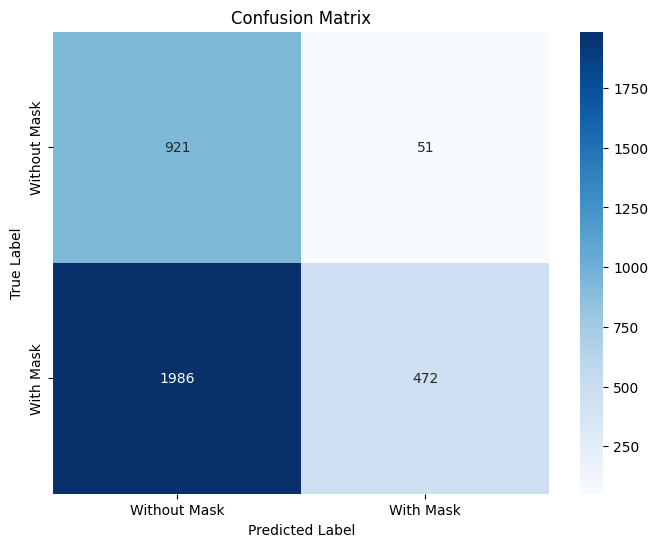

In [ ]:
# 6. Test veri seti üzerinde tahmin yapıyoruz.
predictions = modelMNet.predict(X2_train)

predicted_labels = np.argmax(predictions, axis=1)

loss, accuracy = modelMNet.evaluate(X2_train, Y2_train)
print(f"Test Kayıp (Loss): {loss}")
print(f"Test Doğruluk (Accuracy): {accuracy}")

# 10 kayıt üzerinde tahminler ve doğrulukları gösteriyoruz.
print("ilk 20 Tahmin:", predicted_labels[:20])
print("ilk 20 Doğru Etiket:", np.argmax(Y2_train, axis=1)[:20])

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix oluşturuluyor.
cm = confusion_matrix(np.argmax(Y2_train, axis=1), predicted_labels)

# Confusion matrix çizdiriyoruz.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Without Mask', 'With Mask'],
            yticklabels=['Without Mask', 'With Mask'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.4061224489795918
Precision: 0.9024856596558317
Recall: 0.1920260374288039
Specificity: 0.9475308641975309
F1-score: 0.31667225763166723


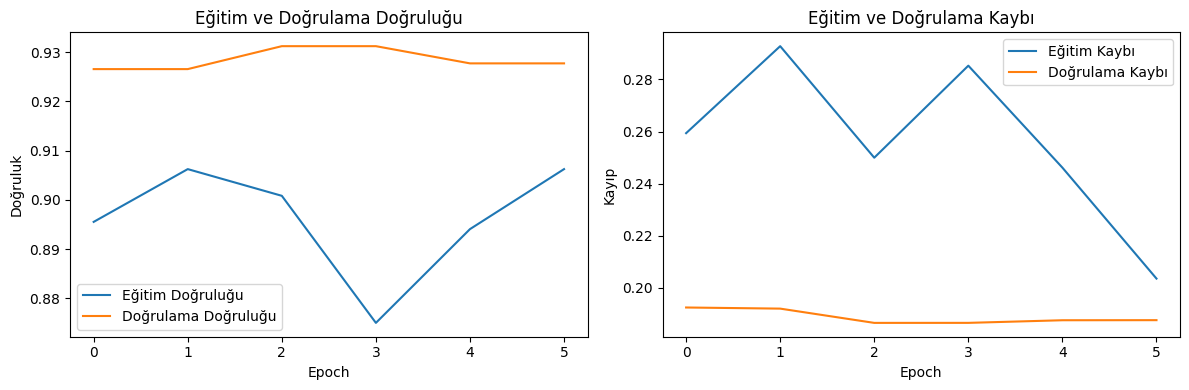

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y2_true = np.argmax(Y2_train, axis=1)
y2_pred = predicted_labels

# Aşağıdaki performans metrikleri hesaplanır.
accuracy = accuracy_score(y2_true, y2_pred)
precision = precision_score(y2_true, y2_pred)
recall = recall_score(y2_true, y2_pred)
f1 = f1_score(y2_true, y2_pred)
tn, fp, fn, tp = confusion_matrix(y2_true, y2_pred).ravel()
specificity = tn / (tn+fp)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1-score: {f1}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()